In [1]:
import brainsss
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#from sklearn.cluster import AgglomerativeClustering
import scipy
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
from scipy.signal import butter, sosfiltfilt, filtfilt, freqz
from scipy import signal
import matplotlib as mpl
from matplotlib.pyplot import cm
import random
from scipy.stats import sem
import time
import h5py
import ants
import nibabel as nib
import matplotlib
from scipy.ndimage import gaussian_filter1d,gaussian_filter
import pickle
from skimage import io, filters
import glob
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.image import grid_to_graph

/home/users/ilanazs/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning:

Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function



In [2]:
fly_num = 'fly_208'
func_path = f'/oak/stanford/groups/trc/data/Ilana/2P/data/{fly_num}/'
# load_directory = os.path.join(func_path, 'func_0/background_subtraction/functional_channel_2_moco.h5')
# save_directory = os.path.join(func_path, 'func_0/background_subtraction/functional_channel_2_moco_highpass_test.h5')
# load_directory = os.path.join(func_path, 'func_0/functional_channel_2_moco_zscore.h5')
warp_directory = os.path.join(func_path,'warp')
load_dir = os.path.join(warp_directory,  'test.h5')

In [3]:
def butter_highpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='high', analog=False)

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y
def apply_butter_highpass(data, z, cutoff, order, fs):

    # Get the filter coefficients so we can check its frequency response.
    b, a = butter_highpass(cutoff, fs, order)
    hpf_data = butter_highpass_filter(data[:,:,z, :], cutoff, fs, order)
    return hpf_data

In [4]:
#filter requirements 
order = 2     # ?? wtf is this??
fs = 1.8      # sample rate, Hz
cutoff = 0.01  # desired cutoff frequency of the filter, Hz

In [5]:
%%time
#from warps

with h5py.File(load_dir, 'r') as wf:
        warps = wf['data'][:]
        ts=wf['timestamps'][:]
        dims = np.shape(warps)
        dimsts = np.shape(ts)
        print("Data shape is {} and TimeStamps shape is {}".format(dims, dimsts))
#         hpf_total = []
#         for z in range(dims[-2]):
#             hpf_data = apply_butter_highpass(warps, z, cutoff, order, fs)
#             hpf_total.append(hpf_data)
#         hpf_total = np.array(hpf_total)
#         hpf_total = np.transpose(hpf_total, (1,2,0,3))
#         dims_hpf = np.shape(hpf_total)
#         print("High Pass Filter Data shape is {}".format(dims_hpf))

Data shape is (314, 146, 91, 500) and TimeStamps shape is (314, 146, 91, 500)
CPU times: user 0 ns, sys: 17.4 s, total: 17.4 s
Wall time: 52.4 s


In [6]:
# warps = np.rollaxis(warps,0,4)
print(np.shape(warps))

(314, 146, 91, 500)


In [7]:
warps.dtype

dtype('<f4')

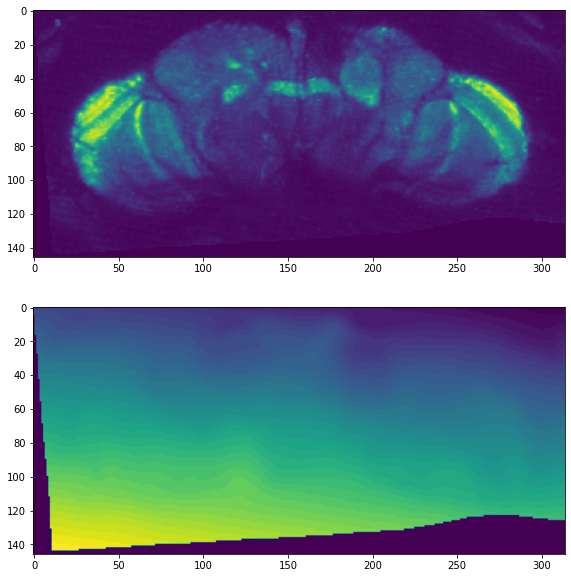

In [9]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.imshow(np.max(warps[:,:,20,:],axis=-1).T)
plt.subplot(2,1,2)
plt.imshow(np.max(ts[:,:,20,:],axis=-1).T)

In [ ]:
# t_start = 1000
# t_end = 1500
# warps_trunc = warps[...,t_start:t_end]

In [10]:
np.shape(warps)

(314, 146, 91, 500)

In [11]:
%%time
warps_blur=[]
for i in range(np.shape(warps)[-1]):
    warps_temp = gaussian_filter(warps[...,i], sigma=2)
    warps_blur.append(warps_temp)
warps_blur=np.asarray(warps_blur)

print(np.shape(warps_blur))

(500, 314, 146, 91)
CPU times: user 1min 34s, sys: 11.5 s, total: 1min 46s
Wall time: 1min 46s


In [12]:
%%time
warps_blur=np.moveaxis(warps_blur,0,-1)
np.shape(warps_blur)
blurred_f = gaussian_filter(warps_blur, sigma=1)
alpha = 30
sharp=warps_blur + alpha * (warps_blur - blurred_f)

CPU times: user 1min 53s, sys: 26.8 s, total: 2min 20s
Wall time: 2min 20s


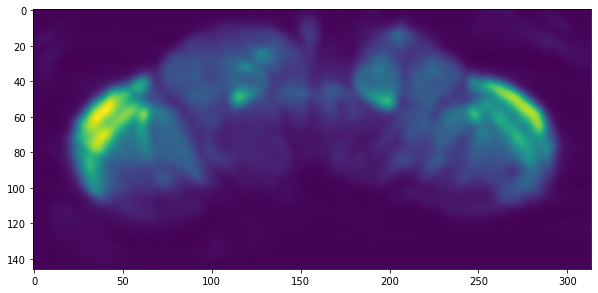

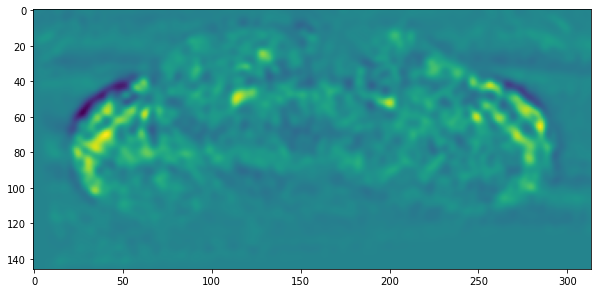

In [13]:
plt.figure(figsize=(10,10))
plt.imshow(warps_blur[:,:,20,100].T)
plt.figure(figsize=(10,10))
plt.imshow(sharp[:,:,20,100].T)

In [14]:
#############
#CHANGE THIS#
#############

warp_def=warps_blur

In [15]:
%%time
hpf_total = []
for z in range(dims[-2]):
    hpf_warps = apply_butter_highpass(warp_def, z, cutoff, order, fs)
    hpf_total.append(hpf_warps)
hpf_total = np.array(hpf_total)
hpf_total = np.transpose(hpf_total, (1,2,0,3))
dims_hpfw = np.shape(hpf_total)
print("High Pass Filter Data shape is {}".format(dims_hpfw))

MemoryError: Unable to allocate 15.5 GiB for an array with shape (91, 314, 146, 500) and data type float64

In [16]:
lpf_total = warp_def-hpf_total
print(np.shape(lpf_total))

MemoryError: Unable to allocate 15.5 GiB for an array with shape (91, 314, 146, 500) and data type float64

In [ ]:
fixed = brainsss.load_fda_meanbrain()
fixed

In [ ]:
np.min(fixed.numpy()) #where all vals are 0 set to 0 in df

In [ ]:
dff=hpf_total/(lpf_total-lpf_total.min()+100)

In [ ]:
dff.mean()

In [ ]:
# plt.hist(lpf_total.flatten(), bins=50)

In [ ]:
dff=np.where(fixed.numpy()[...,None]>0.1, dff, 0)

#dff=np.nan_to_num(dff)


In [ ]:
dff.max()

In [ ]:
# plt.figure(figsize=(10,10))
# plt.imshow(np.max(warps[:,:,20,:], axis=-1).T)
plt.figure(figsize=(10,10))
plt.imshow(np.max(hpf_total[:,:,20, :], axis=-1).T)
plt.figure(figsize=(10,10))
plt.imshow(np.max(lpf_total[:,:,20, :], axis=-1).T)
plt.figure(figsize=(10,10))
plt.imshow(np.max(dff[:,:,20, :], axis=-1).T, vmax=1,vmin=0)

In [ ]:
brain=dff

In [ ]:
shape=np.shape(brain)
print(shape)

In [ ]:
n_clusters = 2000
cluster_dir = os.path.join(func_path, 'clustering')
if not os.path.exists(cluster_dir):
    os.mkdir(cluster_dir)

In [ ]:
%%time
connectivity = grid_to_graph(shape[0],shape[1])
cluster_labels = []
t_shape = shape[3]
for z in range(shape[2]):
    neural_activity = brain[:,:,z,:].reshape(-1, t_shape)
    cluster_model = AgglomerativeClustering(n_clusters=n_clusters,
                                memory=cluster_dir,
                                linkage='ward',
                                connectivity=connectivity)
    cluster_model.fit(neural_activity)
    cluster_labels.append(cluster_model.labels_)
cluster_labels = np.asarray(cluster_labels)

In [ ]:
%%time
all_signals = []
for z in range(shape[2]):
    neural_activity = brain[:,:,z,:].reshape(-1, t_shape)
    signals = []
    for cluster_num in range(n_clusters):
        cluster_indicies = np.where(cluster_labels[z,:]==cluster_num)[0]
        mean_signal = np.mean(neural_activity[cluster_indicies,:], axis=0)
        signals.append(mean_signal)
    signals = np.asarray(signals)
    all_signals.append(signals)
all_signals = np.asarray(all_signals)

In [ ]:
###########################
### PREP VISUAL STIMULI ###
###########################

vision_path = os.path.join(func_path,'func_0', 'visual')

### Load Photodiode ###
t, ft_triggers, pd1, pd2 = brainsss.load_photodiode(vision_path)
stimulus_start_times = brainsss.extract_stim_times_from_pd(pd2, t)

# *100 puts in units of 10ms, which will match fictrac
st_10ms = [int(stimulus_start_times[i]*100) for i in range(len(stimulus_start_times))]

# get 1ms version to match neural timestamps
st_ms= [i*10 for i in st_10ms]
starts_loom = st_10ms

####################
### Prep Fictrac ###
####################

fictrac_path = os.path.join(func_path, 'func_0', 'fictrac')
fictrac_raw = brainsss.load_fictrac(fictrac_path)

fps = 100
resolution = 10 #desired resolution in ms
expt_len = fictrac_raw.shape[0]/fps*1000
behaviors = ['dRotLabY', 'dRotLabZ', 'dRotLabX', 'speed']
fictrac = {}
for behavior in behaviors:
    if behavior == 'dRotLabY': short = 'Y'
    elif behavior == 'dRotLabZ': short = 'Z'
    elif behavior == 'dRotLabX': short = 'X'
    fictrac[short] = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior)
fictrac_timestamps = np.arange(0,expt_len,resolution)

In [ ]:
def extract_traces(fictrac, stim_times, pre_window, post_window, val=None):
    traces = []
    for i in range(len(stim_times)):
        if val != None:
            trace = fictrac[val][stim_times[i]-pre_window:stim_times[i]+post_window]
        else:
            trace = fictrac[stim_times[i]-pre_window:stim_times[i]+post_window]
        if len(trace) == pre_window + post_window: # this handles fictrac that crashed or was aborted or some bullshit
            traces.append(trace)
    traces = np.asarray(traces)
    mean_trace = np.mean(traces,axis=0)
    sem_trace = scipy.stats.sem(traces,axis=0)
    return traces, mean_trace, sem_trace

In [ ]:
###########################################
### Extract Stimulus Triggered Behavior ###
###########################################

pre_window = 200
post_window = 300
# avg_around = 20
stim_time = 100
# window = np.arange(-pre_window,post_window)

behavior_traces = {}
mean_trace = {}
sem_trace = {}
behavior_traces,mean_trace,sem_trace = extract_traces(fictrac['Y'], starts_loom, pre_window, post_window)

In [ ]:
def plot_trace(behavior_trace, pre_window, post_window, stim_time):
    mean_trace = np.mean(behavior_trace, axis=0)
    sem_trace = scipy.stats.sem(behavior_trace, axis=0)
    
    plt.figure(figsize=(10,10))
    plt.plot(mean_trace,color='k',linewidth=3)
    plt.fill_between(np.arange(len(mean_trace)),mean_trace-sem_trace, mean_trace+sem_trace, color='k',alpha=0.3)
    plt.axvline(pre_window,color='k',linestyle='--',lw=2)
    plt.axvline(pre_window+stim_time,color='k',linestyle='--',lw=2)
    plt.ylim(-0.5, 3.5);

In [ ]:
np.shape(behavior_traces)

In [ ]:
plot_trace(behavior_traces, pre_window, post_window, stim_time)

In [ ]:
starts_loom_ms=[n*10 for n in starts_loom]

In [ ]:
bin_start = -500; bin_end = 2000; bin_size = 100 #ms
neural_bins = np.arange(bin_start,bin_end,bin_size)

In [ ]:
np.shape(all_signals)

In [ ]:
def make_STA_brain(neural_signals, neural_timestamps, event_times_list, neural_bins):
    #### super voxel version
    shape=np.shape(neural_signals)
    STA_brain = []
    for z in range(shape[0]):
        all_bin_indicies = []
        for stim_idx in range(len(event_times_list)):
            stim_time = event_times_list[stim_idx]
            stim_centered_bins = neural_bins + stim_time
            bin_indicies = np.digitize(neural_timestamps[:,z] , stim_centered_bins)
            all_bin_indicies.append(bin_indicies)
        all_bin_indicies = np.asarray(all_bin_indicies)
#         print(np.shape(all_bin_indicies))

        avg_neural_across_bins = []
        for bin_num in np.arange(1,len(neural_bins)):
            this_bin_sample_times = list(np.where(all_bin_indicies==bin_num)[1])
            average_neural_in_bin = np.mean(neural_signals[z,:,this_bin_sample_times],axis=0)
            avg_neural_across_bins.append(average_neural_in_bin)
        avg_neural_across_bins = np.asarray(avg_neural_across_bins)
        STA_brain.append(avg_neural_across_bins)
    STA_brain = np.asarray(STA_brain)
    return STA_brain

In [ ]:
STA_brain = make_STA_brain(neural_signals = all_signals,
                                   neural_timestamps = timestamps[t_start:t_end,:],
                                   event_times_list = starts_loom_ms, 
                                   neural_bins = neural_bins)

In [ ]:
np.shape(STA_brain)

In [ ]:
STA_brain = np.nan_to_num(STA_brain)

In [ ]:
def STA_supervoxel_to_full_res(STA_brain, cluster_labels,shape):
    n_clusters = STA_brain.shape[2]
    n_tp = STA_brain.shape[1]
    
    reformed_STA_brain = []
    for z in range(49):
        colored_by_betas = np.zeros((n_tp, shape[0]*shape[1]))
        for cluster_num in range(n_clusters):
            cluster_indicies = np.where(cluster_labels[z,:]==cluster_num)[0]
            colored_by_betas[:,cluster_indicies] = STA_brain[z,:,cluster_num,np.newaxis]
        colored_by_betas = colored_by_betas.reshape(n_tp,shape[0],shape[1])
        reformed_STA_brain.append(colored_by_betas)
    return np.asarray(reformed_STA_brain)

In [ ]:
reformed_STA_brain = STA_supervoxel_to_full_res(STA_brain, cluster_labels,shape)

In [ ]:
np.shape(reformed_STA_brain)

In [ ]:
plt.imshow(np.max(reformed_STA_brain[25][:,:,:], axis=0).T,cmap='bone')

In [ ]:
STA_brain = gaussian_filter1d(reformed_STA_brain,sigma=1,axis=1,truncate=1)
np.shape(STA_brain)

In [ ]:
STA_brain = np.moveaxis(STA_brain,0,-1)
np.shape(STA_brain)

In [ ]:
fixed = brainsss.load_fda_meanbrain()

In [ ]:
atlas = brainsss.load_roi_atlas()

In [ ]:
explosion_rois = brainsss.load_explosion_groups()
all_rois = brainsss.unnest_roi_groups(explosion_rois)
roi_masks = brainsss.make_single_roi_masks(all_rois, atlas)
roi_contours = brainsss.make_single_roi_contours(roi_masks, atlas)

In [ ]:
def extract_roi_signal_traces(roi_ids, roi_masks, warps, hemi, signal_type):
    t0 = time.time()
    roi_time_avgs = []
    for roi in roi_ids[hemi]:
        mask = roi_masks[roi]
        masked_data = warps[:,:,:,:]*mask[np.newaxis,:,:,:] #note z-flip
        if signal_type == 'max':
            roi_time_avg = np.max(masked_data,axis=(1,2,3))
        elif signal_type == 'mean':
            roi_time_avg = np.mean(masked_data,axis=(1,2,3))
        roi_time_avgs.append(roi_time_avg)
    print(time.time()-t0)
    return np.asarray(roi_time_avgs)

In [ ]:
explosions = []
t0 = time.time()
for tp in range(24):
    input_canvas = np.ones((500,500,3)) #+.5 #.5 for diverging
    data_to_plot = STA_brain[tp][:,:,::-1]
    vmax = 0.5 #this was 0.5 for STA <------------
    explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                                        roi_masks,
                                                        roi_contours,
                                                        data_to_plot,
                                                        input_canvas,
                                                        vmax=vmax,
                                                        cmap='seismic', diverging=True)#'hot')
    explosions.append(explosion_map)
print(F'Explosion {time.time()-t0}')